In [7]:
import yfinance as yf # 安装最新版本即可
# 下载SPY和AGG的历史数据
spy_data = yf.download("SPY", start="2000-01-01", end="2023-01-01")
spy_data.columns = [col[0] for col in spy_data.columns]
agg_data = yf.download("AGG", start="2000-01-01", end="2023-01-01")
agg_data.columns = [col[0] for col in agg_data.columns]
spy_data.index = spy_data.index.tz_localize(None)
agg_data.index = agg_data.index.tz_localize(None)

# 保存为CSV文件
spy_data.to_csv("SPY.csv")
agg_data.to_csv("AGG.csv")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
import os
import socket
import pandas as pd
import pytz
import ray

from qstrader.alpha_model.fixed_signals import FixedSignalsAlphaModel
from qstrader.asset.equity import Equity
from qstrader.asset.universe.static import StaticUniverse
from qstrader.data.backtest_data_handler import BacktestDataHandler
from qstrader.data.daily_bar_csv import CSVDailyBarDataSource
from qstrader.statistics.tearsheet import TearsheetStatistics
from qstrader.trading.backtest import BacktestTradingSession
from qstrader.statistics.json_statistics import JSONStatistics

@ray.remote
def run_backtest(start_dt, end_dt, strategy_assets, alpha_model_params, rebalance, long_only, cash_buffer_percentage, strategy_symbols):
    strategy_universe = StaticUniverse(strategy_assets)
    
    csv_dir = '/home/shared/'
    data_source = CSVDailyBarDataSource(csv_dir, Equity, csv_symbols=strategy_symbols)
    data_handler = BacktestDataHandler(strategy_universe, data_sources=[data_source])
    
    strategy_alpha_model = FixedSignalsAlphaModel(alpha_model_params)
    strategy_backtest = BacktestTradingSession(
        start_dt,
        end_dt,
        strategy_universe,
        strategy_alpha_model,
        rebalance=rebalance,
        long_only=long_only,
        cash_buffer_percentage=cash_buffer_percentage,
        data_handler=data_handler
    )
    strategy_backtest.run()
    return strategy_backtest.get_equity_curve()

@ray.remote
def run_benchmark(start_dt, end_dt, benchmark_assets, strategy_symbols):
    benchmark_universe = StaticUniverse(benchmark_assets)
    
    # csv_dir = os.environ.get('QSTRADER_CSV_DATA_DIR', '.')
    csv_dir = '/home/shared/'
    data_source = CSVDailyBarDataSource(csv_dir, Equity, csv_symbols=strategy_symbols)
    data_handler = BacktestDataHandler(benchmark_universe, data_sources=[data_source])
    
    benchmark_alpha_model = FixedSignalsAlphaModel({'EQ:SPY': 1.0})
    benchmark_backtest = BacktestTradingSession(
        start_dt,
        end_dt,
        benchmark_universe,
        benchmark_alpha_model,
        rebalance='buy_and_hold',
        long_only=True,
        cash_buffer_percentage=0.01,
        data_handler=data_handler
    )
    benchmark_backtest.run()
    return benchmark_backtest.get_equity_curve()

def split_time_periods(start_dt, end_dt, num_splits):
    """将时间段分割成多个子时间段"""
    delta = (end_dt - start_dt) / num_splits
    return [(start_dt + i * delta, start_dt + (i + 1) * delta) for i in range(num_splits)]

/opt/conda/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Loading CSV files into DataFrames...
Loading CSV file for symbol 'EQ:SPY'...
Loading CSV file for symbol 'EQ:AGG'...
Adjusting pricing in CSV files...
Adjusting CSV file for symbol 'EQ:SPY'...
Adjusting CSV file for symbol 'EQ:AGG'...
Initialising simulated broker "Backtest Simulated Broker Account"...
(2003-09-30 00:00:00+00:00) - portfolio creation: Portfolio "000001" created at broker "Backtest Simulated Broker Account"
(2003-09-30 00:00:00+00:00) - subscription: 1000000.00 subscribed to portfolio "000001"
Beginning backtest simulation...
(2003-09-30 14:30:00+00:00) - market_open
(2003-09-30 21:00:00+00:00) - market_close
(2003-09-30 21:00:00+00:00) - trading logic and rebalance
(2003-09-30 21:00:00+00:00) - target weights: {'EQ:AGG': 0.4, 'EQ:SPY': 0.6}
(2003-09-30 21:00:00+00:00) - submitted order: EQ:AGG, qty: 7539
(2003-09-30 21:00:00+00:00) - submitted order: EQ:SPY, qty: 8836
(2003-10-01 14:30:00+00:00) - market_open
(2003-10-01 14:30:00+00:00) - executed order: EQ:AGG, qty: 7

/opt/conda/lib/python3.10/site-packages/qstrader/statistics/performance.py:53: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(periods) * (np.mean(returns)) / np.std(returns)
/opt/conda/lib/python3.10/site-packages/qstrader/statistics/performance.py:53: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(periods) * (np.mean(returns)) / np.std(returns)


Plotting the tearsheet...


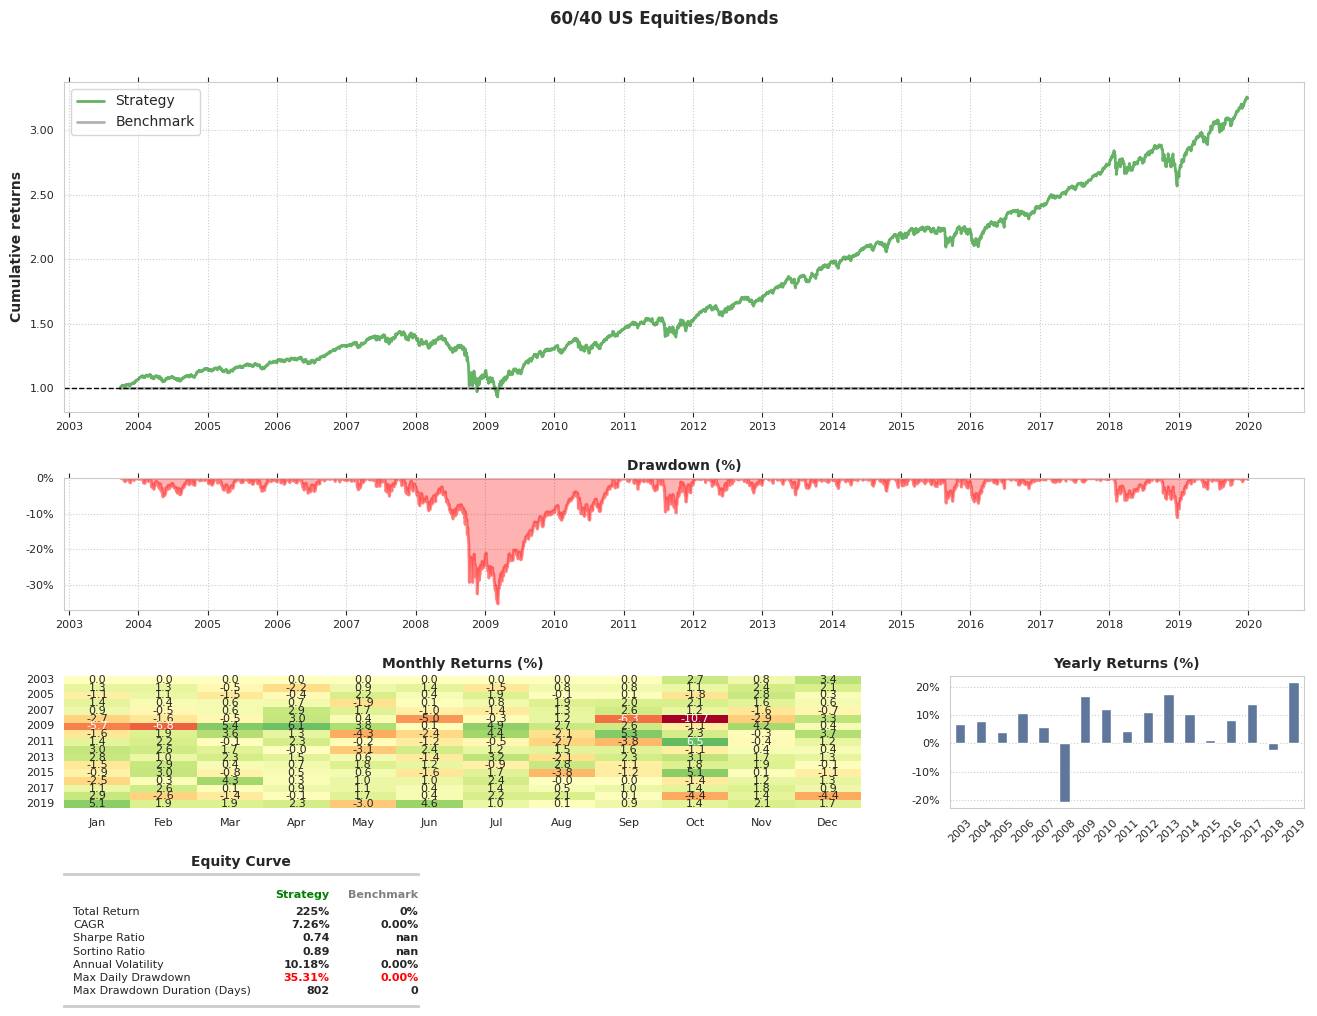

In [1]:
ray.init(address="ray://fsi-ray-head-svc.fsi-ray.svc.cluster.local:10001")  # Initialize Ray

start_dt = pd.Timestamp('2003-09-30 14:30:00', tz=pytz.UTC)
end_dt = pd.Timestamp('2019-12-31 23:59:00', tz=pytz.UTC)

# Strategy backtest parameters
strategy_symbols = ['SPY', 'AGG']
strategy_assets = ['EQ:%s' % symbol for symbol in strategy_symbols]
alpha_model_params = {'EQ:SPY': 0.6, 'EQ:AGG': 0.4}

# 将时间段分割成5个子时间段
time_periods = split_time_periods(start_dt, end_dt, 2)

# 并行运行策略回测
strategy_futures = [
    run_backtest.remote(start, end, strategy_assets, alpha_model_params, 'end_of_month', True, 0.01, strategy_symbols)
    for start, end in time_periods
]

# Benchmark backtest parameters
benchmark_assets = ['EQ:SPY']

# 并行运行基准回测
benchmark_futures = [
    run_benchmark.remote(start, end, benchmark_assets, ['SPY'])
    for start, end in time_periods
]

# 获取结果
strategy_equity_curves = ray.get(strategy_futures)
benchmark_equity_curves = ray.get(benchmark_futures)

# 合并策略的权益曲线
combined_strategy_equity_curve = pd.concat(strategy_equity_curves)
combined_benchmark_equity_curve = pd.concat(benchmark_equity_curves)

# JSON Output
backtest_statistics = JSONStatistics(
    equity_curve=combined_strategy_equity_curve,
    strategy_name="sixty_forty",
    output_filename="sixty_forty_test_%s.json" % socket.gethostname(),
    target_allocations=pd.DataFrame()
)
backtest_statistics.to_file()

# Performance Output
tearsheet = TearsheetStatistics(
    strategy_equity=combined_strategy_equity_curve,
    benchmark_equity=combined_benchmark_equity_curve,
    title='60/40 US Equities/Bonds'
)
tearsheet.plot_results()